In [6]:
#pip install cmdstanpy

In [8]:
import numpy as np
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
# import cmdstanpy
# cmdstanpy.install_cmdstan(compiler=True)

In [11]:
snr_ranges = list(range(-15,31,5))

# snr = -10log(sigma**2)
# sigma_sq = 10**(-snr/10)

sigma_list = []

for snr in snr_ranges:
    sigma_sq = 10**(-snr/10)
    sigma = sigma_sq**0.5
    sigma_list.append(sigma)

sigma_list

[5.623413251903491,
 3.1622776601683795,
 1.7782794100389228,
 1.0,
 0.5623413251903491,
 0.31622776601683794,
 0.17782794100389226,
 0.1,
 0.05623413251903491,
 0.03162277660168379]

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


## Single Example

In [13]:
N = 128
M = 20
sigma = 0.1

# Generate fixed H (measurement matrix)
H = np.random.normal(0, 1, size=(N, M))

# Generate a single sparse x
x_true = np.random.choice([-1, 1], size=M)

# Generate observed Y with Gaussian noise
noise = np.random.normal(0, sigma, N)
R = H @ x_true + noise  # Single observed data point

Y = np.zeros(len(R), dtype=int)  # Initialize Y as integer array
for i in range(len(R)):
    if R[i] >= 0:
        Y[i] = 1


stan_data = {
    "N": N,
    "M": M,
    "Y": Y,
    "H": H,
    "sigma": sigma,
}


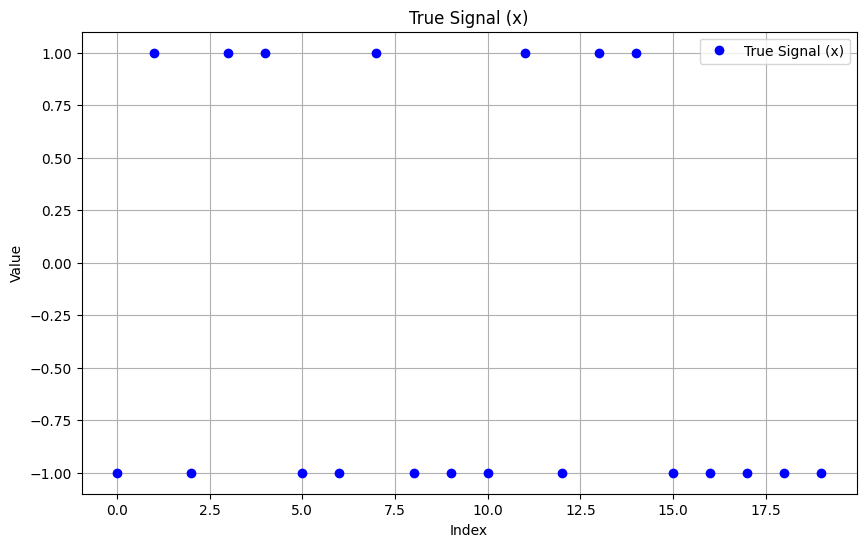

In [14]:
plt.figure(figsize=(10, 6))

# Plot x_true as points
plt.plot(range(M), x_true, 'bo', label='True Signal (x)')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('True Signal (x)')
plt.grid(True)
plt.legend()
plt.show()

In [15]:
model = CmdStanModel(stan_file='class.stan')
fit = model.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=1000, max_treedepth=15)


17:45:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


17:45:51 - cmdstanpy - INFO - CmdStan done processing.


In [16]:
posterior_samples = fit.draws_pd()

mean_x = np.array((posterior_samples.filter(like='x').mean()))
mean_x


array([-1.37836745,  1.30408243, -1.22780822,  1.03176166,  1.34790477,
       -0.95660999, -1.33944062,  1.27209734, -1.08130098, -0.94038359,
       -0.88799686,  0.99572834, -0.93111731,  1.32563692,  1.15421643,
       -1.36990112, -0.51782948, -1.1301319 , -1.29237384, -1.06230107])

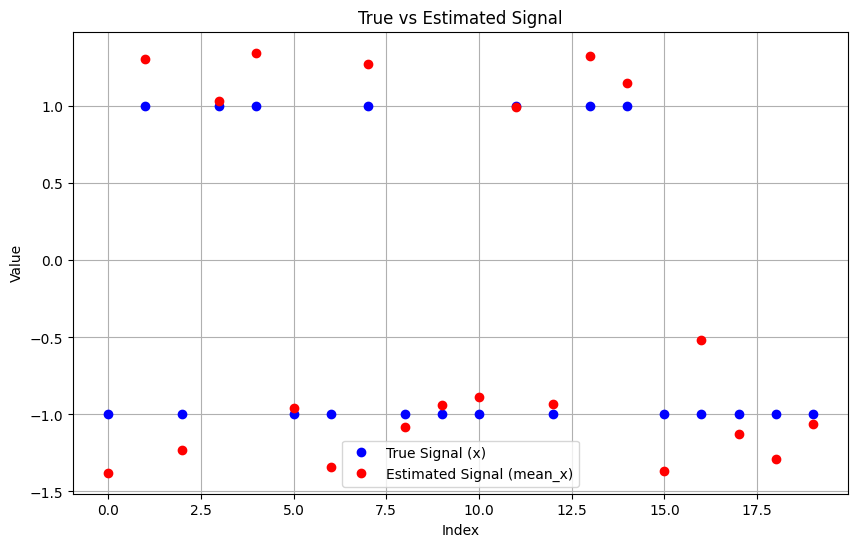

In [17]:
plt.figure(figsize=(10, 6))

# Plot x_true as points
plt.plot(range(M), x_true, 'bo', label='True Signal (x)')

# Plot mean_x as points
plt.plot(range(M), mean_x, 'ro', label='Estimated Signal (mean_x)')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('True vs Estimated Signal')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
fit.summary()

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-35.20760,0.085865,3.319280,3.152450,-41.224900,-34.81130,-30.413200,1510.88,2408.28,1.000840
x[1],-1.37837,0.007529,0.360952,0.362814,-1.985290,-1.37029,-0.796999,2373.93,2705.42,1.002210
x[2],1.30408,0.006450,0.367814,0.361147,0.704986,1.30066,1.903930,3313.45,3228.29,1.000770
x[3],-1.22781,0.006185,0.372632,0.383074,-1.856990,-1.21871,-0.637923,3609.88,3516.62,1.001650
x[4],1.03176,0.005182,0.328453,0.332295,0.509141,1.02565,1.582290,4105.01,2905.56,1.000790
...,...,...,...,...,...,...,...,...,...,...
logits[124],-3.99915,0.019233,1.220990,1.232940,-6.068900,-3.96454,-2.071000,4109.27,3391.68,0.999450
logits[125],4.43530,0.022357,1.375240,1.373310,2.212600,4.42834,6.751010,3826.36,3333.99,1.000550
logits[126],1.91077,0.019700,1.521450,1.531870,-0.469578,1.87179,4.491930,6134.19,3029.40,1.000520
logits[127],-9.66679,0.037543,1.774960,1.741440,-12.641200,-9.68387,-6.770410,2302.64,2632.99,1.000730


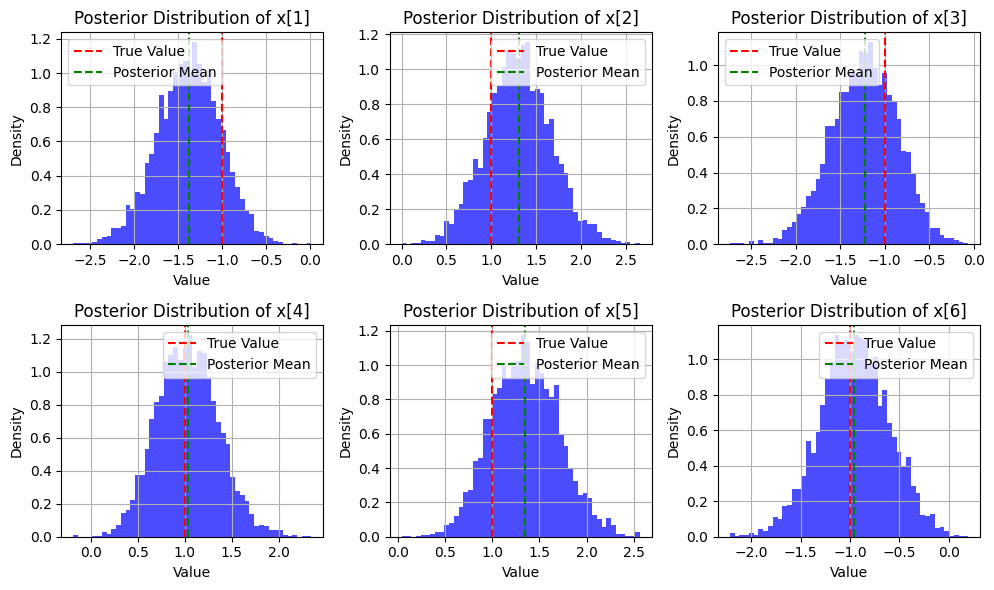

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))  # Changed to 2 rows, 3 columns

for i in range(1, 7):  # Loop from 1 to 6
    x_samples = posterior_samples[f'x[{i}]']  # Get samples for x[i]
    
    ax = axs[(i-1) // 3, (i-1) % 3]  # Updated to determine the subplot position for 2x3
    ax.hist(x_samples, bins=50, density=True, alpha=0.7, color='blue')
    ax.axvline(x=x_true[i-1], color='r', linestyle='--', label='True Value')  # Adjust index for x_true
    ax.axvline(x=mean_x[i-1], color='g', linestyle='--', label='Posterior Mean')  # Adjust index for mean_x
    
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.set_title(f'Posterior Distribution of x[{i}]')  # Update title for each plot
    ax.grid(True)
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [23]:
norm_diff_squared = np.sum((x_true - mean_x)**2)
norm_x_squared = np.sum(x_true**2)
NMSE = norm_diff_squared / norm_x_squared
NMSE_dB = 10 * np.log10(NMSE)

BER = np.sum(np.sign(mean_x) != np.sign(x_true)) / len(x_true)

NMSE, NMSE_dB, BER


(np.float64(0.06168090333433142),
 np.float64(-12.098492745446048),
 np.float64(0.0))

## NMSE and BER for multiple SNRs

In [39]:
import os
from datetime import datetime

def create_snr_files():
    """Create CSV files for each SNR value if they don't exist"""
    os.makedirs('data', exist_ok=True)
    
    # Define base columns
    base_columns = ['timestamp', 'snr', 'sigma', 'nmse', 'ber']
    
    # Add columns for each index of x_true and x_pred
    x_true_cols = [f'x_true_{i}' for i in range(20)]
    x_pred_cols = [f'x_pred_{i}' for i in range(20)]
    
    # Combine all columns
    columns = base_columns + x_true_cols + x_pred_cols
    
    # Create a file for each SNR if it doesn't exist
    for snr in snr_ranges:
        file_path = f'data/results_snr_{snr}dB.csv'
        if not os.path.exists(file_path):
            df = pd.DataFrame(columns=columns)
            df.to_csv(file_path, index=False)
            print(f"Created file: {file_path}")

In [40]:
create_snr_files()

Created file: data/results_snr_-15dB.csv
Created file: data/results_snr_-10dB.csv
Created file: data/results_snr_-5dB.csv
Created file: data/results_snr_0dB.csv
Created file: data/results_snr_5dB.csv
Created file: data/results_snr_10dB.csv
Created file: data/results_snr_15dB.csv
Created file: data/results_snr_20dB.csv
Created file: data/results_snr_25dB.csv
Created file: data/results_snr_30dB.csv


In [44]:
def get_NMSE(N, M, sigma, snr):  # Added snr parameter
    H = np.random.normal(0, 1, size=(N, M))

    # Generate a single sparse x
    x_true = np.random.choice([-1, 1], size=M)

    # Generate observed Y with Gaussian noise
    noise = np.random.normal(0, sigma, N)
    R = H @ x_true + noise  # Single observed data point

    Y = np.zeros(len(R), dtype=int)  # Initialize Y as integer array
    for i in range(len(R)):
        if R[i] >= 0:
            Y[i] = 1

    stan_data = {
        "N": N,
        "M": M,
        "Y": Y,
        "H": H,
        "sigma": sigma,
    }

    model = CmdStanModel(stan_file='class.stan')
    fit = model.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=1000, max_treedepth=15)
    posterior_samples = fit.draws_pd()

    mean_x = np.array((posterior_samples.filter(like='x').mean()))

    norm_diff_squared = np.sum((x_true - mean_x)**2)
    norm_x_squared = np.sum(x_true**2)
    NMSE = norm_diff_squared / norm_x_squared
    NMSE_dB = 10 * np.log10(NMSE)

    BER = np.sum(np.sign(mean_x) != np.sign(x_true)) / len(x_true)

    # Save results to CSV
    file_path = f'data/results_snr_{snr}dB.csv'
    
    new_row = {
        'timestamp': datetime.now(),
        'snr': snr,
        'sigma': sigma,
        'nmse': NMSE_dB,
        'ber': BER,
    }
    
    # Add individual x_true values
    for i, val in enumerate(x_true):
        new_row[f'x_true_{i}'] = val
    
    # Add individual x_pred values
    for i, val in enumerate(mean_x):
        new_row[f'x_pred_{i}'] = val
    
    # Read existing CSV, append new row, and save
    df = pd.read_csv(file_path)
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    df.to_csv(file_path, index=False)

    return NMSE_dB, BER

In [63]:

for sigma_i in range(len(snr_ranges)):
    K = 100              # No. of iterations
    for i in range(K):
        NMSE, BER = get_NMSE(N=128, M=20, sigma=sigma_list[sigma_i], snr=snr_ranges[sigma_i])


18:08:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:20 - cmdstanpy - INFO - CmdStan done processing.


18:08:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:22 - cmdstanpy - INFO - CmdStan done processing.


18:08:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:22 - cmdstanpy - INFO - CmdStan done processing.


18:08:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:23 - cmdstanpy - INFO - CmdStan done processing.


18:08:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:24 - cmdstanpy - INFO - CmdStan done processing.


18:08:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:25 - cmdstanpy - INFO - CmdStan done processing.


18:08:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:26 - cmdstanpy - INFO - CmdStan done processing.


18:08:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:27 - cmdstanpy - INFO - CmdStan done processing.


18:08:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:27 - cmdstanpy - INFO - CmdStan done processing.


18:08:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:28 - cmdstanpy - INFO - CmdStan done processing.


18:08:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:29 - cmdstanpy - INFO - CmdStan done processing.


18:08:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:30 - cmdstanpy - INFO - CmdStan done processing.


18:08:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:31 - cmdstanpy - INFO - CmdStan done processing.


18:08:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:32 - cmdstanpy - INFO - CmdStan done processing.


18:08:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:33 - cmdstanpy - INFO - CmdStan done processing.


18:08:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:33 - cmdstanpy - INFO - CmdStan done processing.


18:08:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:34 - cmdstanpy - INFO - CmdStan done processing.


18:08:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:35 - cmdstanpy - INFO - CmdStan done processing.


18:08:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:08:36 - cmdstanpy - INFO - CmdStan done processing.


18:08:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:37 - cmdstanpy - INFO - CmdStan done processing.


18:08:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:38 - cmdstanpy - INFO - CmdStan done processing.


18:08:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:39 - cmdstanpy - INFO - CmdStan done processing.


18:08:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:39 - cmdstanpy - INFO - CmdStan done processing.


18:08:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:40 - cmdstanpy - INFO - CmdStan done processing.


18:08:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:41 - cmdstanpy - INFO - CmdStan done processing.


18:08:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:42 - cmdstanpy - INFO - CmdStan done processing.


18:08:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:43 - cmdstanpy - INFO - CmdStan done processing.


18:08:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:44 - cmdstanpy - INFO - CmdStan done processing.


18:08:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:45 - cmdstanpy - INFO - CmdStan done processing.


18:08:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:46 - cmdstanpy - INFO - CmdStan done processing.


18:08:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:46 - cmdstanpy - INFO - CmdStan done processing.


18:08:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:47 - cmdstanpy - INFO - CmdStan done processing.


18:08:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:48 - cmdstanpy - INFO - CmdStan done processing.


18:08:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:49 - cmdstanpy - INFO - CmdStan done processing.


18:08:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:50 - cmdstanpy - INFO - CmdStan done processing.


18:08:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:51 - cmdstanpy - INFO - CmdStan done processing.


18:08:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:52 - cmdstanpy - INFO - CmdStan done processing.


18:08:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:52 - cmdstanpy - INFO - CmdStan done processing.


18:08:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:53 - cmdstanpy - INFO - CmdStan done processing.


18:08:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:54 - cmdstanpy - INFO - CmdStan done processing.


18:08:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:55 - cmdstanpy - INFO - CmdStan done processing.


18:08:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:56 - cmdstanpy - INFO - CmdStan done processing.


18:08:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:57 - cmdstanpy - INFO - CmdStan done processing.


18:08:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:57 - cmdstanpy - INFO - CmdStan done processing.


18:08:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:58 - cmdstanpy - INFO - CmdStan done processing.


18:08:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:08:59 - cmdstanpy - INFO - CmdStan done processing.


18:09:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:00 - cmdstanpy - INFO - CmdStan done processing.


18:09:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:01 - cmdstanpy - INFO - CmdStan done processing.


18:09:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:02 - cmdstanpy - INFO - CmdStan done processing.


18:09:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:03 - cmdstanpy - INFO - CmdStan done processing.


18:09:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:04 - cmdstanpy - INFO - CmdStan done processing.


18:09:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:04 - cmdstanpy - INFO - CmdStan done processing.


18:09:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:05 - cmdstanpy - INFO - CmdStan done processing.


18:09:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:06 - cmdstanpy - INFO - CmdStan done processing.


18:09:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:07 - cmdstanpy - INFO - CmdStan done processing.


18:09:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status



chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:08 - cmdstanpy - INFO - CmdStan done processing.


18:09:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:09 - cmdstanpy - INFO - CmdStan done processing.


18:09:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:10 - cmdstanpy - INFO - CmdStan done processing.


18:09:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:11 - cmdstanpy - INFO - CmdStan done processing.


18:09:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:12 - cmdstanpy - INFO - CmdStan done processing.


18:09:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:13 - cmdstanpy - INFO - CmdStan done processing.


18:09:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:13 - cmdstanpy - INFO - CmdStan done processing.


18:09:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:09:14 - cmdstanpy - INFO - CmdStan done processing.


18:09:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:15 - cmdstanpy - INFO - CmdStan done processing.


18:09:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:16 - cmdstanpy - INFO - CmdStan done processing.


18:09:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:17 - cmdstanpy - INFO - CmdStan done processing.


18:09:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:18 - cmdstanpy - INFO - CmdStan done processing.


18:09:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:19 - cmdstanpy - INFO - CmdStan done processing.


18:09:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:19 - cmdstanpy - INFO - CmdStan done processing.


18:09:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:20 - cmdstanpy - INFO - CmdStan done processing.


18:09:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:21 - cmdstanpy - INFO - CmdStan done processing.


18:09:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:09:22 - cmdstanpy - INFO - CmdStan done processing.


18:09:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:23 - cmdstanpy - INFO - CmdStan done processing.


18:09:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:24 - cmdstanpy - INFO - CmdStan done processing.


18:09:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:25 - cmdstanpy - INFO - CmdStan done processing.


18:09:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:25 - cmdstanpy - INFO - CmdStan done processing.


18:09:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:26 - cmdstanpy - INFO - CmdStan done processing.


18:09:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:27 - cmdstanpy - INFO - CmdStan done processing.


18:09:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:28 - cmdstanpy - INFO - CmdStan done processing.


18:09:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:29 - cmdstanpy - INFO - CmdStan done processing.


18:09:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:30 - cmdstanpy - INFO - CmdStan done processing.


18:09:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:31 - cmdstanpy - INFO - CmdStan done processing.


18:09:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:32 - cmdstanpy - INFO - CmdStan done processing.


18:09:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:33 - cmdstanpy - INFO - CmdStan done processing.


18:09:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:33 - cmdstanpy - INFO - CmdStan done processing.


18:09:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:34 - cmdstanpy - INFO - CmdStan done processing.


18:09:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:35 - cmdstanpy - INFO - CmdStan done processing.


18:09:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:36 - cmdstanpy - INFO - CmdStan done processing.


18:09:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:37 - cmdstanpy - INFO - CmdStan done processing.


18:09:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:38 - cmdstanpy - INFO - CmdStan done processing.


18:09:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:39 - cmdstanpy - INFO - CmdStan done processing.


18:09:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:40 - cmdstanpy - INFO - CmdStan done processing.


18:09:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:41 - cmdstanpy - INFO - CmdStan done processing.


18:09:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:42 - cmdstanpy - INFO - CmdStan done processing.


18:09:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:42 - cmdstanpy - INFO - CmdStan done processing.


18:09:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:43 - cmdstanpy - INFO - CmdStan done processing.


18:09:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:44 - cmdstanpy - INFO - CmdStan done processing.


18:09:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:45 - cmdstanpy - INFO - CmdStan done processing.


18:09:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:46 - cmdstanpy - INFO - CmdStan done processing.


18:09:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:47 - cmdstanpy - INFO - CmdStan done processing.


18:09:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:48 - cmdstanpy - INFO - CmdStan done processing.


18:09:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:49 - cmdstanpy - INFO - CmdStan done processing.


18:09:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:49 - cmdstanpy - INFO - CmdStan done processing.


18:09:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:50 - cmdstanpy - INFO - CmdStan done processing.


18:09:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:51 - cmdstanpy - INFO - CmdStan done processing.


18:09:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:52 - cmdstanpy - INFO - CmdStan done processing.


18:09:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:53 - cmdstanpy - INFO - CmdStan done processing.


18:09:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:54 - cmdstanpy - INFO - CmdStan done processing.


18:09:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:55 - cmdstanpy - INFO - CmdStan done processing.


18:09:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:56 - cmdstanpy - INFO - CmdStan done processing.


18:09:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:09:57 - cmdstanpy - INFO - CmdStan done processing.


18:09:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:57 - cmdstanpy - INFO - CmdStan done processing.


18:09:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:58 - cmdstanpy - INFO - CmdStan done processing.


18:09:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:09:59 - cmdstanpy - INFO - CmdStan done processing.


18:10:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:00 - cmdstanpy - INFO - CmdStan done processing.


18:10:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:01 - cmdstanpy - INFO - CmdStan done processing.


18:10:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:02 - cmdstanpy - INFO - CmdStan done processing.


18:10:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:03 - cmdstanpy - INFO - CmdStan done processing.


18:10:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:04 - cmdstanpy - INFO - CmdStan done processing.


18:10:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:04 - cmdstanpy - INFO - CmdStan done processing.


18:10:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:05 - cmdstanpy - INFO - CmdStan done processing.


18:10:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:06 - cmdstanpy - INFO - CmdStan done processing.


18:10:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:07 - cmdstanpy - INFO - CmdStan done processing.


18:10:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:08 - cmdstanpy - INFO - CmdStan done processing.


18:10:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:09 - cmdstanpy - INFO - CmdStan done processing.


18:10:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:10 - cmdstanpy - INFO - CmdStan done processing.


18:10:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:11 - cmdstanpy - INFO - CmdStan done processing.


18:10:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:12 - cmdstanpy - INFO - CmdStan done processing.


18:10:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:13 - cmdstanpy - INFO - CmdStan done processing.


18:10:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:13 - cmdstanpy - INFO - CmdStan done processing.


18:10:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:14 - cmdstanpy - INFO - CmdStan done processing.


18:10:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:15 - cmdstanpy - INFO - CmdStan done processing.


18:10:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:16 - cmdstanpy - INFO - CmdStan done processing.


18:10:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:17 - cmdstanpy - INFO - CmdStan done processing.


18:10:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:18 - cmdstanpy - INFO - CmdStan done processing.


18:10:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:19 - cmdstanpy - INFO - CmdStan done processing.


18:10:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:20 - cmdstanpy - INFO - CmdStan done processing.


18:10:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:21 - cmdstanpy - INFO - CmdStan done processing.


18:10:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:22 - cmdstanpy - INFO - CmdStan done processing.


18:10:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:22 - cmdstanpy - INFO - CmdStan done processing.


18:10:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:23 - cmdstanpy - INFO - CmdStan done processing.


18:10:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:24 - cmdstanpy - INFO - CmdStan done processing.


18:10:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:25 - cmdstanpy - INFO - CmdStan done processing.


18:10:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:26 - cmdstanpy - INFO - CmdStan done processing.


18:10:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:27 - cmdstanpy - INFO - CmdStan done processing.


18:10:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:28 - cmdstanpy - INFO - CmdStan done processing.


18:10:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:29 - cmdstanpy - INFO - CmdStan done processing.


18:10:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:30 - cmdstanpy - INFO - CmdStan done processing.


18:10:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:31 - cmdstanpy - INFO - CmdStan done processing.


18:10:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:32 - cmdstanpy - INFO - CmdStan done processing.


18:10:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:32 - cmdstanpy - INFO - CmdStan done processing.


18:10:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:33 - cmdstanpy - INFO - CmdStan done processing.


18:10:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:34 - cmdstanpy - INFO - CmdStan done processing.


18:10:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:35 - cmdstanpy - INFO - CmdStan done processing.


18:10:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:36 - cmdstanpy - INFO - CmdStan done processing.


18:10:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:37 - cmdstanpy - INFO - CmdStan done processing.


18:10:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:38 - cmdstanpy - INFO - CmdStan done processing.


18:10:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:39 - cmdstanpy - INFO - CmdStan done processing.


18:10:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:39 - cmdstanpy - INFO - CmdStan done processing.


18:10:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:40 - cmdstanpy - INFO - CmdStan done processing.


18:10:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:10:41 - cmdstanpy - INFO - CmdStan done processing.


18:10:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:42 - cmdstanpy - INFO - CmdStan done processing.


18:10:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:43 - cmdstanpy - INFO - CmdStan done processing.


18:10:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:44 - cmdstanpy - INFO - CmdStan done processing.


18:10:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:45 - cmdstanpy - INFO - CmdStan done processing.


18:10:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:46 - cmdstanpy - INFO - CmdStan done processing.


18:10:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:46 - cmdstanpy - INFO - CmdStan done processing.


18:10:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:48 - cmdstanpy - INFO - CmdStan done processing.


18:10:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:48 - cmdstanpy - INFO - CmdStan done processing.


18:10:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:49 - cmdstanpy - INFO - CmdStan done processing.


18:10:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status




chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:50 - cmdstanpy - INFO - CmdStan done processing.


18:10:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:51 - cmdstanpy - INFO - CmdStan done processing.


18:10:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:52 - cmdstanpy - INFO - CmdStan done processing.


18:10:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:53 - cmdstanpy - INFO - CmdStan done processing.


18:10:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:54 - cmdstanpy - INFO - CmdStan done processing.


18:10:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:55 - cmdstanpy - INFO - CmdStan done processing.


18:10:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:56 - cmdstanpy - INFO - CmdStan done processing.


18:10:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:57 - cmdstanpy - INFO - CmdStan done processing.


18:10:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:58 - cmdstanpy - INFO - CmdStan done processing.


18:10:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:10:58 - cmdstanpy - INFO - CmdStan done processing.


18:10:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:10:59 - cmdstanpy - INFO - CmdStan done processing.


18:11:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:00 - cmdstanpy - INFO - CmdStan done processing.


18:11:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:01 - cmdstanpy - INFO - CmdStan done processing.


18:11:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:02 - cmdstanpy - INFO - CmdStan done processing.


18:11:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:03 - cmdstanpy - INFO - CmdStan done processing.


18:11:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:04 - cmdstanpy - INFO - CmdStan done processing.


18:11:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:05 - cmdstanpy - INFO - CmdStan done processing.


18:11:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:06 - cmdstanpy - INFO - CmdStan done processing.


18:11:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:07 - cmdstanpy - INFO - CmdStan done processing.


18:11:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:07 - cmdstanpy - INFO - CmdStan done processing.


18:11:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:08 - cmdstanpy - INFO - CmdStan done processing.


18:11:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:09 - cmdstanpy - INFO - CmdStan done processing.


18:11:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:10 - cmdstanpy - INFO - CmdStan done processing.


18:11:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:11 - cmdstanpy - INFO - CmdStan done processing.


18:11:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:12 - cmdstanpy - INFO - CmdStan done processing.


18:11:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:13 - cmdstanpy - INFO - CmdStan done processing.


18:11:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:14 - cmdstanpy - INFO - CmdStan done processing.


18:11:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:15 - cmdstanpy - INFO - CmdStan done processing.


18:11:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:15 - cmdstanpy - INFO - CmdStan done processing.


18:11:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:16 - cmdstanpy - INFO - CmdStan done processing.


18:11:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:17 - cmdstanpy - INFO - CmdStan done processing.


18:11:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:18 - cmdstanpy - INFO - CmdStan done processing.


18:11:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:19 - cmdstanpy - INFO - CmdStan done processing.


18:11:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:20 - cmdstanpy - INFO - CmdStan done processing.


18:11:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:21 - cmdstanpy - INFO - CmdStan done processing.


18:11:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:22 - cmdstanpy - INFO - CmdStan done processing.


18:11:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:23 - cmdstanpy - INFO - CmdStan done processing.


18:11:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:24 - cmdstanpy - INFO - CmdStan done processing.


18:11:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:24 - cmdstanpy - INFO - CmdStan done processing.


18:11:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:25 - cmdstanpy - INFO - CmdStan done processing.


18:11:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:26 - cmdstanpy - INFO - CmdStan done processing.


18:11:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:27 - cmdstanpy - INFO - CmdStan done processing.


18:11:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:28 - cmdstanpy - INFO - CmdStan done processing.


18:11:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:29 - cmdstanpy - INFO - CmdStan done processing.


18:11:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:30 - cmdstanpy - INFO - CmdStan done processing.


18:11:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:31 - cmdstanpy - INFO - CmdStan done processing.


18:11:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:32 - cmdstanpy - INFO - CmdStan done processing.


18:11:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:32 - cmdstanpy - INFO - CmdStan done processing.


18:11:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:33 - cmdstanpy - INFO - CmdStan done processing.


18:11:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:34 - cmdstanpy - INFO - CmdStan done processing.


18:11:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:35 - cmdstanpy - INFO - CmdStan done processing.


18:11:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:36 - cmdstanpy - INFO - CmdStan done processing.


18:11:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:37 - cmdstanpy - INFO - CmdStan done processing.


18:11:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:38 - cmdstanpy - INFO - CmdStan done processing.


18:11:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:39 - cmdstanpy - INFO - CmdStan done processing.


18:11:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:40 - cmdstanpy - INFO - CmdStan done processing.


18:11:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:41 - cmdstanpy - INFO - CmdStan done processing.


18:11:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:41 - cmdstanpy - INFO - CmdStan done processing.


18:11:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:42 - cmdstanpy - INFO - CmdStan done processing.


18:11:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status




chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:43 - cmdstanpy - INFO - CmdStan done processing.


18:11:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:44 - cmdstanpy - INFO - CmdStan done processing.


18:11:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:45 - cmdstanpy - INFO - CmdStan done processing.


18:11:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:46 - cmdstanpy - INFO - CmdStan done processing.


18:11:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:47 - cmdstanpy - INFO - CmdStan done processing.


18:11:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:48 - cmdstanpy - INFO - CmdStan done processing.


18:11:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:49 - cmdstanpy - INFO - CmdStan done processing.


18:11:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:50 - cmdstanpy - INFO - CmdStan done processing.


18:11:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:51 - cmdstanpy - INFO - CmdStan done processing.


18:11:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:52 - cmdstanpy - INFO - CmdStan done processing.


18:11:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:52 - cmdstanpy - INFO - CmdStan done processing.


18:11:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:53 - cmdstanpy - INFO - CmdStan done processing.


18:11:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:54 - cmdstanpy - INFO - CmdStan done processing.


18:11:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:55 - cmdstanpy - INFO - CmdStan done processing.


18:11:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:56 - cmdstanpy - INFO - CmdStan done processing.


18:11:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:57 - cmdstanpy - INFO - CmdStan done processing.


18:11:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:58 - cmdstanpy - INFO - CmdStan done processing.


18:11:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:11:59 - cmdstanpy - INFO - CmdStan done processing.


18:11:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:00 - cmdstanpy - INFO - CmdStan done processing.


18:12:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:01 - cmdstanpy - INFO - CmdStan done processing.


18:12:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:01 - cmdstanpy - INFO - CmdStan done processing.


18:12:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)





chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:03 - cmdstanpy - INFO - CmdStan done processing.


18:12:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:04 - cmdstanpy - INFO - CmdStan done processing.


18:12:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:04 - cmdstanpy - INFO - CmdStan done processing.


18:12:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:05 - cmdstanpy - INFO - CmdStan done processing.


18:12:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:06 - cmdstanpy - INFO - CmdStan done processing.


18:12:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:07 - cmdstanpy - INFO - CmdStan done processing.


18:12:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:08 - cmdstanpy - INFO - CmdStan done processing.


18:12:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:09 - cmdstanpy - INFO - CmdStan done processing.


18:12:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:10 - cmdstanpy - INFO - CmdStan done processing.


18:12:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:12:11 - cmdstanpy - INFO - CmdStan done processing.


18:12:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:12 - cmdstanpy - INFO - CmdStan done processing.


18:12:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:13 - cmdstanpy - INFO - CmdStan done processing.


18:12:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:14 - cmdstanpy - INFO - CmdStan done processing.


18:12:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:15 - cmdstanpy - INFO - CmdStan done processing.


18:12:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:16 - cmdstanpy - INFO - CmdStan done processing.


18:12:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status



chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:17 - cmdstanpy - INFO - CmdStan done processing.


18:12:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:12:18 - cmdstanpy - INFO - CmdStan done processing.


18:12:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:19 - cmdstanpy - INFO - CmdStan done processing.


18:12:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:20 - cmdstanpy - INFO - CmdStan done processing.


18:12:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:21 - cmdstanpy - INFO - CmdStan done processing.


18:12:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:22 - cmdstanpy - INFO - CmdStan done processing.


18:12:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:23 - cmdstanpy - INFO - CmdStan done processing.


18:12:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:24 - cmdstanpy - INFO - CmdStan done processing.


18:12:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:25 - cmdstanpy - INFO - CmdStan done processing.


18:12:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:25 - cmdstanpy - INFO - CmdStan done processing.


18:12:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:26 - cmdstanpy - INFO - CmdStan done processing.


18:12:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:27 - cmdstanpy - INFO - CmdStan done processing.


18:12:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:28 - cmdstanpy - INFO - CmdStan done processing.


18:12:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:29 - cmdstanpy - INFO - CmdStan done processing.


18:12:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:30 - cmdstanpy - INFO - CmdStan done processing.


18:12:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:31 - cmdstanpy - INFO - CmdStan done processing.


18:12:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:32 - cmdstanpy - INFO - CmdStan done processing.


18:12:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:33 - cmdstanpy - INFO - CmdStan done processing.


18:12:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:34 - cmdstanpy - INFO - CmdStan done processing.


18:12:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:35 - cmdstanpy - INFO - CmdStan done processing.


18:12:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:36 - cmdstanpy - INFO - CmdStan done processing.


18:12:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:37 - cmdstanpy - INFO - CmdStan done processing.


18:12:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:37 - cmdstanpy - INFO - CmdStan done processing.


18:12:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:38 - cmdstanpy - INFO - CmdStan done processing.


18:12:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:39 - cmdstanpy - INFO - CmdStan done processing.


18:12:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:40 - cmdstanpy - INFO - CmdStan done processing.


18:12:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:41 - cmdstanpy - INFO - CmdStan done processing.


18:12:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:42 - cmdstanpy - INFO - CmdStan done processing.


18:12:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:43 - cmdstanpy - INFO - CmdStan done processing.


18:12:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:44 - cmdstanpy - INFO - CmdStan done processing.


18:12:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:45 - cmdstanpy - INFO - CmdStan done processing.


18:12:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:46 - cmdstanpy - INFO - CmdStan done processing.


18:12:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:47 - cmdstanpy - INFO - CmdStan done processing.


18:12:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:48 - cmdstanpy - INFO - CmdStan done processing.


18:12:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:49 - cmdstanpy - INFO - CmdStan done processing.


18:12:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:49 - cmdstanpy - INFO - CmdStan done processing.


18:12:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:50 - cmdstanpy - INFO - CmdStan done processing.


18:12:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:51 - cmdstanpy - INFO - CmdStan done processing.


18:12:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:52 - cmdstanpy - INFO - CmdStan done processing.


18:12:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:53 - cmdstanpy - INFO - CmdStan done processing.


18:12:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:54 - cmdstanpy - INFO - CmdStan done processing.


18:12:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:55 - cmdstanpy - INFO - CmdStan done processing.


18:12:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:56 - cmdstanpy - INFO - CmdStan done processing.


18:12:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:57 - cmdstanpy - INFO - CmdStan done processing.


18:12:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:58 - cmdstanpy - INFO - CmdStan done processing.


18:12:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:59 - cmdstanpy - INFO - CmdStan done processing.


18:12:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:12:59 - cmdstanpy - INFO - CmdStan done processing.


18:13:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:00 - cmdstanpy - INFO - CmdStan done processing.


18:13:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:02 - cmdstanpy - INFO - CmdStan done processing.


18:13:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:02 - cmdstanpy - INFO - CmdStan done processing.


18:13:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:03 - cmdstanpy - INFO - CmdStan done processing.


18:13:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:04 - cmdstanpy - INFO - CmdStan done processing.


18:13:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:05 - cmdstanpy - INFO - CmdStan done processing.


18:13:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:06 - cmdstanpy - INFO - CmdStan done processing.


18:13:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:07 - cmdstanpy - INFO - CmdStan done processing.


18:13:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:08 - cmdstanpy - INFO - CmdStan done processing.


18:13:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:09 - cmdstanpy - INFO - CmdStan done processing.


18:13:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:10 - cmdstanpy - INFO - CmdStan done processing.


18:13:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:11 - cmdstanpy - INFO - CmdStan done processing.


18:13:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status
chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:12 - cmdstanpy - INFO - CmdStan done processing.


18:13:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:13 - cmdstanpy - INFO - CmdStan done processing.


18:13:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:14 - cmdstanpy - INFO - CmdStan done processing.


18:13:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:15 - cmdstanpy - INFO - CmdStan done processing.


18:13:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:16 - cmdstanpy - INFO - CmdStan done processing.


18:13:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:17 - cmdstanpy - INFO - CmdStan done processing.


18:13:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:17 - cmdstanpy - INFO - CmdStan done processing.


18:13:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:18 - cmdstanpy - INFO - CmdStan done processing.


18:13:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:19 - cmdstanpy - INFO - CmdStan done processing.


18:13:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:20 - cmdstanpy - INFO - CmdStan done processing.


18:13:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:21 - cmdstanpy - INFO - CmdStan done processing.


18:13:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:22 - cmdstanpy - INFO - CmdStan done processing.


18:13:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:23 - cmdstanpy - INFO - CmdStan done processing.


18:13:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:24 - cmdstanpy - INFO - CmdStan done processing.


18:13:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:25 - cmdstanpy - INFO - CmdStan done processing.


18:13:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:26 - cmdstanpy - INFO - CmdStan done processing.


18:13:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:27 - cmdstanpy - INFO - CmdStan done processing.


18:13:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:28 - cmdstanpy - INFO - CmdStan done processing.


18:13:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:29 - cmdstanpy - INFO - CmdStan done processing.


18:13:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:29 - cmdstanpy - INFO - CmdStan done processing.


18:13:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)





chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:30 - cmdstanpy - INFO - CmdStan done processing.


18:13:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:31 - cmdstanpy - INFO - CmdStan done processing.


18:13:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:32 - cmdstanpy - INFO - CmdStan done processing.


18:13:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:33 - cmdstanpy - INFO - CmdStan done processing.


18:13:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:34 - cmdstanpy - INFO - CmdStan done processing.


18:13:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:13:35 - cmdstanpy - INFO - CmdStan done processing.


18:13:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:36 - cmdstanpy - INFO - CmdStan done processing.


18:13:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:37 - cmdstanpy - INFO - CmdStan done processing.


18:13:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:38 - cmdstanpy - INFO - CmdStan done processing.


18:13:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:39 - cmdstanpy - INFO - CmdStan done processing.


18:13:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:40 - cmdstanpy - INFO - CmdStan done processing.


18:13:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:41 - cmdstanpy - INFO - CmdStan done processing.


18:13:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:42 - cmdstanpy - INFO - CmdStan done processing.


18:13:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:43 - cmdstanpy - INFO - CmdStan done processing.


18:13:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:43 - cmdstanpy - INFO - CmdStan done processing.


18:13:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:44 - cmdstanpy - INFO - CmdStan done processing.


18:13:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:45 - cmdstanpy - INFO - CmdStan done processing.


18:13:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:46 - cmdstanpy - INFO - CmdStan done processing.


18:13:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:47 - cmdstanpy - INFO - CmdStan done processing.


18:13:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:48 - cmdstanpy - INFO - CmdStan done processing.


18:13:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)








chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:50 - cmdstanpy - INFO - CmdStan done processing.


18:13:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:51 - cmdstanpy - INFO - CmdStan done processing.


18:13:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:52 - cmdstanpy - INFO - CmdStan done processing.


18:13:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:52 - cmdstanpy - INFO - CmdStan done processing.


18:13:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:53 - cmdstanpy - INFO - CmdStan done processing.


18:13:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:54 - cmdstanpy - INFO - CmdStan done processing.


18:13:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:55 - cmdstanpy - INFO - CmdStan done processing.


18:13:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:56 - cmdstanpy - INFO - CmdStan done processing.


18:13:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status




chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


18:13:58 - cmdstanpy - INFO - CmdStan done processing.


18:13:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:13:59 - cmdstanpy - INFO - CmdStan done processing.


18:13:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:00 - cmdstanpy - INFO - CmdStan done processing.


18:14:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:01 - cmdstanpy - INFO - CmdStan done processing.


18:14:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:02 - cmdstanpy - INFO - CmdStan done processing.


18:14:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:03 - cmdstanpy - INFO - CmdStan done processing.


18:14:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:04 - cmdstanpy - INFO - CmdStan done processing.


18:14:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:05 - cmdstanpy - INFO - CmdStan done processing.


18:14:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:06 - cmdstanpy - INFO - CmdStan done processing.


18:14:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:07 - cmdstanpy - INFO - CmdStan done processing.


18:14:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status

chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:08 - cmdstanpy - INFO - CmdStan done processing.


18:14:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:09 - cmdstanpy - INFO - CmdStan done processing.


18:14:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:10 - cmdstanpy - INFO - CmdStan done processing.


18:14:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:11 - cmdstanpy - INFO - CmdStan done processing.


18:14:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:12 - cmdstanpy - INFO - CmdStan done processing.


18:14:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:13 - cmdstanpy - INFO - CmdStan done processing.


18:14:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:14 - cmdstanpy - INFO - CmdStan done processing.


18:14:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:14 - cmdstanpy - INFO - CmdStan done processing.


18:14:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:15 - cmdstanpy - INFO - CmdStan done processing.


18:14:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:16 - cmdstanpy - INFO - CmdStan done processing.


18:14:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:17 - cmdstanpy - INFO - CmdStan done processing.


18:14:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:18 - cmdstanpy - INFO - CmdStan done processing.


18:14:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:19 - cmdstanpy - INFO - CmdStan done processing.


18:14:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:20 - cmdstanpy - INFO - CmdStan done processing.


18:14:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:21 - cmdstanpy - INFO - CmdStan done processing.


18:14:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:22 - cmdstanpy - INFO - CmdStan done processing.


18:14:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)




chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:23 - cmdstanpy - INFO - CmdStan done processing.


18:14:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:24 - cmdstanpy - INFO - CmdStan done processing.


18:14:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:25 - cmdstanpy - INFO - CmdStan done processing.


18:14:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:26 - cmdstanpy - INFO - CmdStan done processing.


18:14:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:27 - cmdstanpy - INFO - CmdStan done processing.


18:14:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:28 - cmdstanpy - INFO - CmdStan done processing.


18:14:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:29 - cmdstanpy - INFO - CmdStan done processing.


18:14:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:30 - cmdstanpy - INFO - CmdStan done processing.


18:14:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:14:30 - cmdstanpy - INFO - CmdStan done processing.


18:14:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:31 - cmdstanpy - INFO - CmdStan done processing.


18:14:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:32 - cmdstanpy - INFO - CmdStan done processing.


18:14:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:33 - cmdstanpy - INFO - CmdStan done processing.


18:14:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:34 - cmdstanpy - INFO - CmdStan done processing.


18:14:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:35 - cmdstanpy - INFO - CmdStan done processing.


18:14:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:36 - cmdstanpy - INFO - CmdStan done processing.


18:14:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:37 - cmdstanpy - INFO - CmdStan done processing.


18:14:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:38 - cmdstanpy - INFO - CmdStan done processing.


18:14:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:39 - cmdstanpy - INFO - CmdStan done processing.


18:14:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:40 - cmdstanpy - INFO - CmdStan done processing.


18:14:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:41 - cmdstanpy - INFO - CmdStan done processing.


18:14:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:42 - cmdstanpy - INFO - CmdStan done processing.


18:14:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:42 - cmdstanpy - INFO - CmdStan done processing.


18:14:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:43 - cmdstanpy - INFO - CmdStan done processing.


18:14:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:44 - cmdstanpy - INFO - CmdStan done processing.


18:14:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:45 - cmdstanpy - INFO - CmdStan done processing.


18:14:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:46 - cmdstanpy - INFO - CmdStan done processing.


18:14:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:47 - cmdstanpy - INFO - CmdStan done processing.


18:14:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:48 - cmdstanpy - INFO - CmdStan done processing.


18:14:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:49 - cmdstanpy - INFO - CmdStan done processing.


18:14:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:50 - cmdstanpy - INFO - CmdStan done processing.


18:14:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:51 - cmdstanpy - INFO - CmdStan done processing.


18:14:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:52 - cmdstanpy - INFO - CmdStan done processing.


18:14:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status



chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:14:53 - cmdstanpy - INFO - CmdStan done processing.


18:14:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:54 - cmdstanpy - INFO - CmdStan done processing.


18:14:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:14:55 - cmdstanpy - INFO - CmdStan done processing.


18:14:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:55 - cmdstanpy - INFO - CmdStan done processing.


18:14:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:14:56 - cmdstanpy - INFO - CmdStan done processing.


18:14:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:57 - cmdstanpy - INFO - CmdStan done processing.


18:14:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:58 - cmdstanpy - INFO - CmdStan done processing.


18:14:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:14:59 - cmdstanpy - INFO - CmdStan done processing.


18:15:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:00 - cmdstanpy - INFO - CmdStan done processing.


18:15:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:01 - cmdstanpy - INFO - CmdStan done processing.


18:15:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:02 - cmdstanpy - INFO - CmdStan done processing.


18:15:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:03 - cmdstanpy - INFO - CmdStan done processing.


18:15:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:04 - cmdstanpy - INFO - CmdStan done processing.


18:15:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:05 - cmdstanpy - INFO - CmdStan done processing.


18:15:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:06 - cmdstanpy - INFO - CmdStan done processing.


18:15:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:07 - cmdstanpy - INFO - CmdStan done processing.


18:15:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:08 - cmdstanpy - INFO - CmdStan done processing.


18:15:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:09 - cmdstanpy - INFO - CmdStan done processing.


18:15:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:10 - cmdstanpy - INFO - CmdStan done processing.


18:15:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:11 - cmdstanpy - INFO - CmdStan done processing.


18:15:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:12 - cmdstanpy - INFO - CmdStan done processing.


18:15:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:12 - cmdstanpy - INFO - CmdStan done processing.


18:15:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:13 - cmdstanpy - INFO - CmdStan done processing.


18:15:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:14 - cmdstanpy - INFO - CmdStan done processing.


18:15:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:15 - cmdstanpy - INFO - CmdStan done processing.


18:15:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status

chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:16 - cmdstanpy - INFO - CmdStan done processing.


18:15:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:17 - cmdstanpy - INFO - CmdStan done processing.


18:15:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:18 - cmdstanpy - INFO - CmdStan done processing.


18:15:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:19 - cmdstanpy - INFO - CmdStan done processing.


18:15:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:20 - cmdstanpy - INFO - CmdStan done processing.


18:15:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:21 - cmdstanpy - INFO - CmdStan done processing.


18:15:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:22 - cmdstanpy - INFO - CmdStan done processing.


18:15:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:23 - cmdstanpy - INFO - CmdStan done processing.


18:15:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:24 - cmdstanpy - INFO - CmdStan done processing.


18:15:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:25 - cmdstanpy - INFO - CmdStan done processing.


18:15:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:26 - cmdstanpy - INFO - CmdStan done processing.


18:15:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:26 - cmdstanpy - INFO - CmdStan done processing.


18:15:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:27 - cmdstanpy - INFO - CmdStan done processing.


18:15:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:28 - cmdstanpy - INFO - CmdStan done processing.


18:15:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:29 - cmdstanpy - INFO - CmdStan done processing.


18:15:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:30 - cmdstanpy - INFO - CmdStan done processing.


18:15:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:31 - cmdstanpy - INFO - CmdStan done processing.


18:15:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:32 - cmdstanpy - INFO - CmdStan done processing.


18:15:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:33 - cmdstanpy - INFO - CmdStan done processing.


18:15:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:34 - cmdstanpy - INFO - CmdStan done processing.


18:15:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:35 - cmdstanpy - INFO - CmdStan done processing.


18:15:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:36 - cmdstanpy - INFO - CmdStan done processing.


18:15:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:37 - cmdstanpy - INFO - CmdStan done processing.


18:15:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:38 - cmdstanpy - INFO - CmdStan done processing.


18:15:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:39 - cmdstanpy - INFO - CmdStan done processing.


18:15:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:40 - cmdstanpy - INFO - CmdStan done processing.


18:15:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:41 - cmdstanpy - INFO - CmdStan done processing.


18:15:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:42 - cmdstanpy - INFO - CmdStan done processing.


18:15:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:43 - cmdstanpy - INFO - CmdStan done processing.


18:15:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:44 - cmdstanpy - INFO - CmdStan done processing.


18:15:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:44 - cmdstanpy - INFO - CmdStan done processing.


18:15:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:45 - cmdstanpy - INFO - CmdStan done processing.


18:15:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:46 - cmdstanpy - INFO - CmdStan done processing.


18:15:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:47 - cmdstanpy - INFO - CmdStan done processing.


18:15:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:48 - cmdstanpy - INFO - CmdStan done processing.


18:15:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status




chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:49 - cmdstanpy - INFO - CmdStan done processing.


18:15:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:50 - cmdstanpy - INFO - CmdStan done processing.


18:15:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:51 - cmdstanpy - INFO - CmdStan done processing.


18:15:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:52 - cmdstanpy - INFO - CmdStan done processing.


18:15:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:53 - cmdstanpy - INFO - CmdStan done processing.


18:15:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:54 - cmdstanpy - INFO - CmdStan done processing.


18:15:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:55 - cmdstanpy - INFO - CmdStan done processing.


18:15:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:56 - cmdstanpy - INFO - CmdStan done processing.


18:15:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:57 - cmdstanpy - INFO - CmdStan done processing.


18:15:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:58 - cmdstanpy - INFO - CmdStan done processing.


18:15:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:15:59 - cmdstanpy - INFO - CmdStan done processing.


18:16:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:00 - cmdstanpy - INFO - CmdStan done processing.


18:16:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:01 - cmdstanpy - INFO - CmdStan done processing.


18:16:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:02 - cmdstanpy - INFO - CmdStan done processing.


18:16:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:03 - cmdstanpy - INFO - CmdStan done processing.


18:16:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:04 - cmdstanpy - INFO - CmdStan done processing.


18:16:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:05 - cmdstanpy - INFO - CmdStan done processing.


18:16:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:06 - cmdstanpy - INFO - CmdStan done processing.


18:16:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:07 - cmdstanpy - INFO - CmdStan done processing.


18:16:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:08 - cmdstanpy - INFO - CmdStan done processing.


18:16:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:09 - cmdstanpy - INFO - CmdStan done processing.


18:16:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:10 - cmdstanpy - INFO - CmdStan done processing.


18:16:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:11 - cmdstanpy - INFO - CmdStan done processing.


18:16:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:12 - cmdstanpy - INFO - CmdStan done processing.


18:16:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:13 - cmdstanpy - INFO - CmdStan done processing.


18:16:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:14 - cmdstanpy - INFO - CmdStan done processing.


18:16:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:14 - cmdstanpy - INFO - CmdStan done processing.


18:16:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:15 - cmdstanpy - INFO - CmdStan done processing.


18:16:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:16 - cmdstanpy - INFO - CmdStan done processing.


18:16:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:17 - cmdstanpy - INFO - CmdStan done processing.


18:16:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:18 - cmdstanpy - INFO - CmdStan done processing.


18:16:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:19 - cmdstanpy - INFO - CmdStan done processing.


18:16:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:20 - cmdstanpy - INFO - CmdStan done processing.


18:16:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:21 - cmdstanpy - INFO - CmdStan done processing.


18:16:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:22 - cmdstanpy - INFO - CmdStan done processing.


18:16:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:23 - cmdstanpy - INFO - CmdStan done processing.


18:16:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:24 - cmdstanpy - INFO - CmdStan done processing.


18:16:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       


chain 4 |██████████| 00:00 Sampling completed


18:16:26 - cmdstanpy - INFO - CmdStan done processing.


18:16:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:27 - cmdstanpy - INFO - CmdStan done processing.


18:16:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:28 - cmdstanpy - INFO - CmdStan done processing.


18:16:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:29 - cmdstanpy - INFO - CmdStan done processing.


18:16:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:30 - cmdstanpy - INFO - CmdStan done processing.


18:16:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:30 - cmdstanpy - INFO - CmdStan done processing.


18:16:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:32 - cmdstanpy - INFO - CmdStan done processing.


18:16:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:32 - cmdstanpy - INFO - CmdStan done processing.


18:16:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:16:33 - cmdstanpy - INFO - CmdStan done processing.


18:16:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:34 - cmdstanpy - INFO - CmdStan done processing.


18:16:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:36 - cmdstanpy - INFO - CmdStan done processing.


18:16:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:36 - cmdstanpy - INFO - CmdStan done processing.


18:16:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:37 - cmdstanpy - INFO - CmdStan done processing.


18:16:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:38 - cmdstanpy - INFO - CmdStan done processing.


18:16:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:39 - cmdstanpy - INFO - CmdStan done processing.


18:16:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:40 - cmdstanpy - INFO - CmdStan done processing.


18:16:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:41 - cmdstanpy - INFO - CmdStan done processing.


18:16:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:42 - cmdstanpy - INFO - CmdStan done processing.


18:16:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:43 - cmdstanpy - INFO - CmdStan done processing.


18:16:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:44 - cmdstanpy - INFO - CmdStan done processing.


18:16:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:45 - cmdstanpy - INFO - CmdStan done processing.


18:16:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:46 - cmdstanpy - INFO - CmdStan done processing.


18:16:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:47 - cmdstanpy - INFO - CmdStan done processing.


18:16:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:48 - cmdstanpy - INFO - CmdStan done processing.


18:16:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:49 - cmdstanpy - INFO - CmdStan done processing.


18:16:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:50 - cmdstanpy - INFO - CmdStan done processing.


18:16:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:51 - cmdstanpy - INFO - CmdStan done processing.


18:16:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:52 - cmdstanpy - INFO - CmdStan done processing.


18:16:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:52 - cmdstanpy - INFO - CmdStan done processing.


18:16:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:53 - cmdstanpy - INFO - CmdStan done processing.


18:16:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:54 - cmdstanpy - INFO - CmdStan done processing.


18:16:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)








chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:56 - cmdstanpy - INFO - CmdStan done processing.


18:16:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:57 - cmdstanpy - INFO - CmdStan done processing.


18:16:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:58 - cmdstanpy - INFO - CmdStan done processing.


18:16:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:16:59 - cmdstanpy - INFO - CmdStan done processing.


18:16:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:00 - cmdstanpy - INFO - CmdStan done processing.


18:17:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:01 - cmdstanpy - INFO - CmdStan done processing.


18:17:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:01 - cmdstanpy - INFO - CmdStan done processing.


18:17:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:03 - cmdstanpy - INFO - CmdStan done processing.


18:17:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:03 - cmdstanpy - INFO - CmdStan done processing.


18:17:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:04 - cmdstanpy - INFO - CmdStan done processing.


18:17:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:05 - cmdstanpy - INFO - CmdStan done processing.


18:17:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:06 - cmdstanpy - INFO - CmdStan done processing.


18:17:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:07 - cmdstanpy - INFO - CmdStan done processing.


18:17:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:09 - cmdstanpy - INFO - CmdStan done processing.


18:17:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:10 - cmdstanpy - INFO - CmdStan done processing.


18:17:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:11 - cmdstanpy - INFO - CmdStan done processing.


18:17:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:12 - cmdstanpy - INFO - CmdStan done processing.


18:17:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:12 - cmdstanpy - INFO - CmdStan done processing.


18:17:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:13 - cmdstanpy - INFO - CmdStan done processing.


18:17:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:14 - cmdstanpy - INFO - CmdStan done processing.


18:17:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:15 - cmdstanpy - INFO - CmdStan done processing.


18:17:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:16 - cmdstanpy - INFO - CmdStan done processing.


18:17:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:17 - cmdstanpy - INFO - CmdStan done processing.


18:17:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:18 - cmdstanpy - INFO - CmdStan done processing.


18:17:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:19 - cmdstanpy - INFO - CmdStan done processing.


18:17:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:20 - cmdstanpy - INFO - CmdStan done processing.


18:17:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:21 - cmdstanpy - INFO - CmdStan done processing.


18:17:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:22 - cmdstanpy - INFO - CmdStan done processing.


18:17:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:23 - cmdstanpy - INFO - CmdStan done processing.


18:17:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:24 - cmdstanpy - INFO - CmdStan done processing.


18:17:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:24 - cmdstanpy - INFO - CmdStan done processing.


18:17:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:25 - cmdstanpy - INFO - CmdStan done processing.


18:17:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status

chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:26 - cmdstanpy - INFO - CmdStan done processing.


18:17:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:27 - cmdstanpy - INFO - CmdStan done processing.


18:17:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:28 - cmdstanpy - INFO - CmdStan done processing.


18:17:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:29 - cmdstanpy - INFO - CmdStan done processing.


18:17:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:30 - cmdstanpy - INFO - CmdStan done processing.


18:17:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:31 - cmdstanpy - INFO - CmdStan done processing.


18:17:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:32 - cmdstanpy - INFO - CmdStan done processing.


18:17:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:33 - cmdstanpy - INFO - CmdStan done processing.


18:17:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:34 - cmdstanpy - INFO - CmdStan done processing.


18:17:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:35 - cmdstanpy - INFO - CmdStan done processing.


18:17:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:36 - cmdstanpy - INFO - CmdStan done processing.


18:17:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:37 - cmdstanpy - INFO - CmdStan done processing.


18:17:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:38 - cmdstanpy - INFO - CmdStan done processing.


18:17:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:39 - cmdstanpy - INFO - CmdStan done processing.


18:17:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:40 - cmdstanpy - INFO - CmdStan done processing.


18:17:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:41 - cmdstanpy - INFO - CmdStan done processing.


18:17:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:42 - cmdstanpy - INFO - CmdStan done processing.


18:17:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:43 - cmdstanpy - INFO - CmdStan done processing.


18:17:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:17:44 - cmdstanpy - INFO - CmdStan done processing.


18:17:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:45 - cmdstanpy - INFO - CmdStan done processing.


18:17:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:46 - cmdstanpy - INFO - CmdStan done processing.


18:17:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:47 - cmdstanpy - INFO - CmdStan done processing.


18:17:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:47 - cmdstanpy - INFO - CmdStan done processing.


18:17:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:49 - cmdstanpy - INFO - CmdStan done processing.


18:17:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:50 - cmdstanpy - INFO - CmdStan done processing.


18:17:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:51 - cmdstanpy - INFO - CmdStan done processing.


18:17:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:52 - cmdstanpy - INFO - CmdStan done processing.


18:17:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:52 - cmdstanpy - INFO - CmdStan done processing.


18:17:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:53 - cmdstanpy - INFO - CmdStan done processing.


18:17:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:54 - cmdstanpy - INFO - CmdStan done processing.


18:17:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:55 - cmdstanpy - INFO - CmdStan done processing.


18:17:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:56 - cmdstanpy - INFO - CmdStan done processing.


18:17:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:57 - cmdstanpy - INFO - CmdStan done processing.


18:17:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:58 - cmdstanpy - INFO - CmdStan done processing.


18:17:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:17:59 - cmdstanpy - INFO - CmdStan done processing.


18:18:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:00 - cmdstanpy - INFO - CmdStan done processing.


18:18:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:01 - cmdstanpy - INFO - CmdStan done processing.


18:18:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:02 - cmdstanpy - INFO - CmdStan done processing.


18:18:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:03 - cmdstanpy - INFO - CmdStan done processing.


18:18:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:04 - cmdstanpy - INFO - CmdStan done processing.


18:18:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:05 - cmdstanpy - INFO - CmdStan done processing.


18:18:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:06 - cmdstanpy - INFO - CmdStan done processing.


18:18:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:07 - cmdstanpy - INFO - CmdStan done processing.


18:18:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:08 - cmdstanpy - INFO - CmdStan done processing.


18:18:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:09 - cmdstanpy - INFO - CmdStan done processing.


18:18:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:10 - cmdstanpy - INFO - CmdStan done processing.


18:18:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:11 - cmdstanpy - INFO - CmdStan done processing.


18:18:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:12 - cmdstanpy - INFO - CmdStan done processing.


18:18:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:12 - cmdstanpy - INFO - CmdStan done processing.


18:18:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:13 - cmdstanpy - INFO - CmdStan done processing.


18:18:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:14 - cmdstanpy - INFO - CmdStan done processing.


18:18:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:15 - cmdstanpy - INFO - CmdStan done processing.


18:18:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:16 - cmdstanpy - INFO - CmdStan done processing.


18:18:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:17 - cmdstanpy - INFO - CmdStan done processing.


18:18:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:18 - cmdstanpy - INFO - CmdStan done processing.


18:18:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:19 - cmdstanpy - INFO - CmdStan done processing.


18:18:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:20 - cmdstanpy - INFO - CmdStan done processing.


18:18:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:21 - cmdstanpy - INFO - CmdStan done processing.


18:18:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:22 - cmdstanpy - INFO - CmdStan done processing.


18:18:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:23 - cmdstanpy - INFO - CmdStan done processing.


18:18:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:24 - cmdstanpy - INFO - CmdStan done processing.


18:18:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:25 - cmdstanpy - INFO - CmdStan done processing.


18:18:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:26 - cmdstanpy - INFO - CmdStan done processing.


18:18:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:27 - cmdstanpy - INFO - CmdStan done processing.


18:18:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:28 - cmdstanpy - INFO - CmdStan done processing.


18:18:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:28 - cmdstanpy - INFO - CmdStan done processing.


18:18:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:29 - cmdstanpy - INFO - CmdStan done processing.


18:18:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:30 - cmdstanpy - INFO - CmdStan done processing.


18:18:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:31 - cmdstanpy - INFO - CmdStan done processing.


18:18:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:33 - cmdstanpy - INFO - CmdStan done processing.


18:18:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:34 - cmdstanpy - INFO - CmdStan done processing.


18:18:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:34 - cmdstanpy - INFO - CmdStan done processing.


18:18:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:35 - cmdstanpy - INFO - CmdStan done processing.


18:18:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:36 - cmdstanpy - INFO - CmdStan done processing.


18:18:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:37 - cmdstanpy - INFO - CmdStan done processing.


18:18:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:38 - cmdstanpy - INFO - CmdStan done processing.


18:18:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:39 - cmdstanpy - INFO - CmdStan done processing.


18:18:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:40 - cmdstanpy - INFO - CmdStan done processing.


18:18:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:41 - cmdstanpy - INFO - CmdStan done processing.


18:18:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:42 - cmdstanpy - INFO - CmdStan done processing.


18:18:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:43 - cmdstanpy - INFO - CmdStan done processing.


18:18:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:44 - cmdstanpy - INFO - CmdStan done processing.


18:18:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:45 - cmdstanpy - INFO - CmdStan done processing.


18:18:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:46 - cmdstanpy - INFO - CmdStan done processing.


18:18:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:47 - cmdstanpy - INFO - CmdStan done processing.


18:18:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:48 - cmdstanpy - INFO - CmdStan done processing.


18:18:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:49 - cmdstanpy - INFO - CmdStan done processing.


18:18:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:50 - cmdstanpy - INFO - CmdStan done processing.


18:18:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:50 - cmdstanpy - INFO - CmdStan done processing.


18:18:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:51 - cmdstanpy - INFO - CmdStan done processing.


18:18:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:52 - cmdstanpy - INFO - CmdStan done processing.


18:18:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:53 - cmdstanpy - INFO - CmdStan done processing.


18:18:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:54 - cmdstanpy - INFO - CmdStan done processing.


18:18:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:55 - cmdstanpy - INFO - CmdStan done processing.


18:18:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:56 - cmdstanpy - INFO - CmdStan done processing.


18:18:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:57 - cmdstanpy - INFO - CmdStan done processing.


18:18:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:58 - cmdstanpy - INFO - CmdStan done processing.


18:18:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:18:59 - cmdstanpy - INFO - CmdStan done processing.


18:19:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:00 - cmdstanpy - INFO - CmdStan done processing.


18:19:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:01 - cmdstanpy - INFO - CmdStan done processing.


18:19:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:02 - cmdstanpy - INFO - CmdStan done processing.


18:19:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:03 - cmdstanpy - INFO - CmdStan done processing.


18:19:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:04 - cmdstanpy - INFO - CmdStan done processing.


18:19:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:05 - cmdstanpy - INFO - CmdStan done processing.


18:19:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:06 - cmdstanpy - INFO - CmdStan done processing.


18:19:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:07 - cmdstanpy - INFO - CmdStan done processing.


18:19:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:19:08 - cmdstanpy - INFO - CmdStan done processing.


18:19:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:09 - cmdstanpy - INFO - CmdStan done processing.


18:19:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:10 - cmdstanpy - INFO - CmdStan done processing.


18:19:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:11 - cmdstanpy - INFO - CmdStan done processing.


18:19:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:12 - cmdstanpy - INFO - CmdStan done processing.


18:19:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:13 - cmdstanpy - INFO - CmdStan done processing.


18:19:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:14 - cmdstanpy - INFO - CmdStan done processing.


18:19:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:15 - cmdstanpy - INFO - CmdStan done processing.


18:19:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:16 - cmdstanpy - INFO - CmdStan done processing.


18:19:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:17 - cmdstanpy - INFO - CmdStan done processing.


18:19:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:18 - cmdstanpy - INFO - CmdStan done processing.


18:19:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:19 - cmdstanpy - INFO - CmdStan done processing.


18:19:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:20 - cmdstanpy - INFO - CmdStan done processing.


18:19:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:21 - cmdstanpy - INFO - CmdStan done processing.


18:19:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:22 - cmdstanpy - INFO - CmdStan done processing.


18:19:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:23 - cmdstanpy - INFO - CmdStan done processing.


18:19:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:23 - cmdstanpy - INFO - CmdStan done processing.


18:19:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:24 - cmdstanpy - INFO - CmdStan done processing.


18:19:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:25 - cmdstanpy - INFO - CmdStan done processing.


18:19:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:26 - cmdstanpy - INFO - CmdStan done processing.


18:19:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:27 - cmdstanpy - INFO - CmdStan done processing.


18:19:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:28 - cmdstanpy - INFO - CmdStan done processing.


18:19:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:29 - cmdstanpy - INFO - CmdStan done processing.


18:19:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:30 - cmdstanpy - INFO - CmdStan done processing.


18:19:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:31 - cmdstanpy - INFO - CmdStan done processing.


18:19:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:32 - cmdstanpy - INFO - CmdStan done processing.


18:19:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:33 - cmdstanpy - INFO - CmdStan done processing.


18:19:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:34 - cmdstanpy - INFO - CmdStan done processing.


18:19:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:35 - cmdstanpy - INFO - CmdStan done processing.


18:19:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:36 - cmdstanpy - INFO - CmdStan done processing.


18:19:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:37 - cmdstanpy - INFO - CmdStan done processing.


18:19:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:38 - cmdstanpy - INFO - CmdStan done processing.


18:19:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:39 - cmdstanpy - INFO - CmdStan done processing.


18:19:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:40 - cmdstanpy - INFO - CmdStan done processing.


18:19:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:40 - cmdstanpy - INFO - CmdStan done processing.


18:19:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:41 - cmdstanpy - INFO - CmdStan done processing.


18:19:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:42 - cmdstanpy - INFO - CmdStan done processing.


18:19:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:43 - cmdstanpy - INFO - CmdStan done processing.


18:19:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:44 - cmdstanpy - INFO - CmdStan done processing.


18:19:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:45 - cmdstanpy - INFO - CmdStan done processing.


18:19:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:46 - cmdstanpy - INFO - CmdStan done processing.


18:19:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:47 - cmdstanpy - INFO - CmdStan done processing.


18:19:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:48 - cmdstanpy - INFO - CmdStan done processing.


18:19:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:49 - cmdstanpy - INFO - CmdStan done processing.


18:19:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:50 - cmdstanpy - INFO - CmdStan done processing.


18:19:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:51 - cmdstanpy - INFO - CmdStan done processing.


18:19:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:52 - cmdstanpy - INFO - CmdStan done processing.


18:19:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:19:53 - cmdstanpy - INFO - CmdStan done processing.


18:19:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:54 - cmdstanpy - INFO - CmdStan done processing.


18:19:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:55 - cmdstanpy - INFO - CmdStan done processing.


18:19:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:56 - cmdstanpy - INFO - CmdStan done processing.


18:19:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:57 - cmdstanpy - INFO - CmdStan done processing.


18:19:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:57 - cmdstanpy - INFO - CmdStan done processing.


18:19:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:19:58 - cmdstanpy - INFO - CmdStan done processing.


18:19:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:19:59 - cmdstanpy - INFO - CmdStan done processing.


18:20:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:00 - cmdstanpy - INFO - CmdStan done processing.


18:20:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:01 - cmdstanpy - INFO - CmdStan done processing.


18:20:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:02 - cmdstanpy - INFO - CmdStan done processing.


18:20:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:03 - cmdstanpy - INFO - CmdStan done processing.


18:20:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:04 - cmdstanpy - INFO - CmdStan done processing.


18:20:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:05 - cmdstanpy - INFO - CmdStan done processing.


18:20:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:06 - cmdstanpy - INFO - CmdStan done processing.


18:20:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:07 - cmdstanpy - INFO - CmdStan done processing.


18:20:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:08 - cmdstanpy - INFO - CmdStan done processing.


18:20:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:09 - cmdstanpy - INFO - CmdStan done processing.


18:20:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:10 - cmdstanpy - INFO - CmdStan done processing.


18:20:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:11 - cmdstanpy - INFO - CmdStan done processing.


18:20:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:12 - cmdstanpy - INFO - CmdStan done processing.


18:20:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:13 - cmdstanpy - INFO - CmdStan done processing.


18:20:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:14 - cmdstanpy - INFO - CmdStan done processing.


18:20:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:15 - cmdstanpy - INFO - CmdStan done processing.


18:20:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:20:16 - cmdstanpy - INFO - CmdStan done processing.


18:20:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:17 - cmdstanpy - INFO - CmdStan done processing.


18:20:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:18 - cmdstanpy - INFO - CmdStan done processing.


18:20:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:19 - cmdstanpy - INFO - CmdStan done processing.


18:20:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:19 - cmdstanpy - INFO - CmdStan done processing.


18:20:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:20 - cmdstanpy - INFO - CmdStan done processing.


18:20:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:21 - cmdstanpy - INFO - CmdStan done processing.


18:20:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:22 - cmdstanpy - INFO - CmdStan done processing.


18:20:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:23 - cmdstanpy - INFO - CmdStan done processing.


18:20:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:24 - cmdstanpy - INFO - CmdStan done processing.


18:20:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:20:25 - cmdstanpy - INFO - CmdStan done processing.


18:20:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:26 - cmdstanpy - INFO - CmdStan done processing.


18:20:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:27 - cmdstanpy - INFO - CmdStan done processing.


18:20:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:28 - cmdstanpy - INFO - CmdStan done processing.


18:20:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:29 - cmdstanpy - INFO - CmdStan done processing.


18:20:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:30 - cmdstanpy - INFO - CmdStan done processing.


18:20:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:31 - cmdstanpy - INFO - CmdStan done processing.


18:20:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:32 - cmdstanpy - INFO - CmdStan done processing.


18:20:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:33 - cmdstanpy - INFO - CmdStan done processing.


18:20:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:34 - cmdstanpy - INFO - CmdStan done processing.


18:20:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:35 - cmdstanpy - INFO - CmdStan done processing.


18:20:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:36 - cmdstanpy - INFO - CmdStan done processing.


18:20:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:37 - cmdstanpy - INFO - CmdStan done processing.


18:20:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status

chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:38 - cmdstanpy - INFO - CmdStan done processing.


18:20:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:39 - cmdstanpy - INFO - CmdStan done processing.


18:20:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:20:40 - cmdstanpy - INFO - CmdStan done processing.


18:20:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:20:42 - cmdstanpy - INFO - CmdStan done processing.


18:20:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:42 - cmdstanpy - INFO - CmdStan done processing.


18:20:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:43 - cmdstanpy - INFO - CmdStan done processing.


18:20:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:44 - cmdstanpy - INFO - CmdStan done processing.


18:20:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:45 - cmdstanpy - INFO - CmdStan done processing.


18:20:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:46 - cmdstanpy - INFO - CmdStan done processing.


18:20:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:47 - cmdstanpy - INFO - CmdStan done processing.


18:20:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:48 - cmdstanpy - INFO - CmdStan done processing.


18:20:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:49 - cmdstanpy - INFO - CmdStan done processing.


18:20:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:50 - cmdstanpy - INFO - CmdStan done processing.


18:20:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:51 - cmdstanpy - INFO - CmdStan done processing.


18:20:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:52 - cmdstanpy - INFO - CmdStan done processing.


18:20:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:53 - cmdstanpy - INFO - CmdStan done processing.


18:20:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:54 - cmdstanpy - INFO - CmdStan done processing.


18:20:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)




chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:55 - cmdstanpy - INFO - CmdStan done processing.


18:20:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:56 - cmdstanpy - INFO - CmdStan done processing.


18:20:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:57 - cmdstanpy - INFO - CmdStan done processing.


18:20:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:58 - cmdstanpy - INFO - CmdStan done processing.


18:20:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:20:59 - cmdstanpy - INFO - CmdStan done processing.


18:20:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:00 - cmdstanpy - INFO - CmdStan done processing.


18:21:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:01 - cmdstanpy - INFO - CmdStan done processing.


18:21:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:02 - cmdstanpy - INFO - CmdStan done processing.


18:21:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:03 - cmdstanpy - INFO - CmdStan done processing.


18:21:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:04 - cmdstanpy - INFO - CmdStan done processing.


18:21:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:05 - cmdstanpy - INFO - CmdStan done processing.


18:21:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:06 - cmdstanpy - INFO - CmdStan done processing.


18:21:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:07 - cmdstanpy - INFO - CmdStan done processing.


18:21:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:08 - cmdstanpy - INFO - CmdStan done processing.


18:21:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:09 - cmdstanpy - INFO - CmdStan done processing.


18:21:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:10 - cmdstanpy - INFO - CmdStan done processing.


18:21:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:11 - cmdstanpy - INFO - CmdStan done processing.


18:21:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:12 - cmdstanpy - INFO - CmdStan done processing.


18:21:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:13 - cmdstanpy - INFO - CmdStan done processing.


18:21:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:14 - cmdstanpy - INFO - CmdStan done processing.


18:21:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:15 - cmdstanpy - INFO - CmdStan done processing.


18:21:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:16 - cmdstanpy - INFO - CmdStan done processing.


18:21:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:17 - cmdstanpy - INFO - CmdStan done processing.


18:21:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:18 - cmdstanpy - INFO - CmdStan done processing.


18:21:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:19 - cmdstanpy - INFO - CmdStan done processing.


18:21:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:19 - cmdstanpy - INFO - CmdStan done processing.


18:21:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:20 - cmdstanpy - INFO - CmdStan done processing.


18:21:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:21 - cmdstanpy - INFO - CmdStan done processing.


18:21:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:22 - cmdstanpy - INFO - CmdStan done processing.


18:21:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:23 - cmdstanpy - INFO - CmdStan done processing.


18:21:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:24 - cmdstanpy - INFO - CmdStan done processing.


18:21:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:25 - cmdstanpy - INFO - CmdStan done processing.


18:21:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:26 - cmdstanpy - INFO - CmdStan done processing.


18:21:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:27 - cmdstanpy - INFO - CmdStan done processing.


18:21:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:28 - cmdstanpy - INFO - CmdStan done processing.


18:21:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:29 - cmdstanpy - INFO - CmdStan done processing.


18:21:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:30 - cmdstanpy - INFO - CmdStan done processing.


18:21:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:31 - cmdstanpy - INFO - CmdStan done processing.


18:21:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:32 - cmdstanpy - INFO - CmdStan done processing.


18:21:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:33 - cmdstanpy - INFO - CmdStan done processing.


18:21:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


18:21:34 - cmdstanpy - INFO - CmdStan done processing.


18:21:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:35 - cmdstanpy - INFO - CmdStan done processing.


18:21:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:36 - cmdstanpy - INFO - CmdStan done processing.


18:21:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)





chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:37 - cmdstanpy - INFO - CmdStan done processing.


18:21:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:38 - cmdstanpy - INFO - CmdStan done processing.


18:21:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:39 - cmdstanpy - INFO - CmdStan done processing.


18:21:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:21:40 - cmdstanpy - INFO - CmdStan done processing.


18:21:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:41 - cmdstanpy - INFO - CmdStan done processing.


18:21:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:42 - cmdstanpy - INFO - CmdStan done processing.


18:21:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status




chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:43 - cmdstanpy - INFO - CmdStan done processing.


18:21:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:44 - cmdstanpy - INFO - CmdStan done processing.


18:21:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:45 - cmdstanpy - INFO - CmdStan done processing.


18:21:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:46 - cmdstanpy - INFO - CmdStan done processing.


18:21:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:47 - cmdstanpy - INFO - CmdStan done processing.


18:21:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:48 - cmdstanpy - INFO - CmdStan done processing.


18:21:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:49 - cmdstanpy - INFO - CmdStan done processing.


18:21:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:50 - cmdstanpy - INFO - CmdStan done processing.


18:21:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:51 - cmdstanpy - INFO - CmdStan done processing.


18:21:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:51 - cmdstanpy - INFO - CmdStan done processing.


18:21:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:52 - cmdstanpy - INFO - CmdStan done processing.


18:21:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:21:53 - cmdstanpy - INFO - CmdStan done processing.


18:21:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:54 - cmdstanpy - INFO - CmdStan done processing.


18:21:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:55 - cmdstanpy - INFO - CmdStan done processing.


18:21:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:56 - cmdstanpy - INFO - CmdStan done processing.


18:21:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:57 - cmdstanpy - INFO - CmdStan done processing.


18:21:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:58 - cmdstanpy - INFO - CmdStan done processing.


18:21:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:59 - cmdstanpy - INFO - CmdStan done processing.


18:22:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:00 - cmdstanpy - INFO - CmdStan done processing.


18:22:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:01 - cmdstanpy - INFO - CmdStan done processing.


18:22:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:02 - cmdstanpy - INFO - CmdStan done processing.


18:22:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:03 - cmdstanpy - INFO - CmdStan done processing.


18:22:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:04 - cmdstanpy - INFO - CmdStan done processing.


18:22:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:05 - cmdstanpy - INFO - CmdStan done processing.


18:22:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:06 - cmdstanpy - INFO - CmdStan done processing.


18:22:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:06 - cmdstanpy - INFO - CmdStan done processing.


18:22:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:07 - cmdstanpy - INFO - CmdStan done processing.


18:22:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:08 - cmdstanpy - INFO - CmdStan done processing.


18:22:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:10 - cmdstanpy - INFO - CmdStan done processing.


18:22:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:10 - cmdstanpy - INFO - CmdStan done processing.


18:22:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:11 - cmdstanpy - INFO - CmdStan done processing.


18:22:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:12 - cmdstanpy - INFO - CmdStan done processing.


18:22:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:13 - cmdstanpy - INFO - CmdStan done processing.


18:22:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:14 - cmdstanpy - INFO - CmdStan done processing.


18:22:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:15 - cmdstanpy - INFO - CmdStan done processing.


18:22:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:16 - cmdstanpy - INFO - CmdStan done processing.


18:22:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:17 - cmdstanpy - INFO - CmdStan done processing.


18:22:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:18 - cmdstanpy - INFO - CmdStan done processing.


18:22:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:19 - cmdstanpy - INFO - CmdStan done processing.


18:22:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:20 - cmdstanpy - INFO - CmdStan done processing.


18:22:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:21 - cmdstanpy - INFO - CmdStan done processing.


18:22:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:22 - cmdstanpy - INFO - CmdStan done processing.


18:22:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:23 - cmdstanpy - INFO - CmdStan done processing.


18:22:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:24 - cmdstanpy - INFO - CmdStan done processing.


18:22:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:25 - cmdstanpy - INFO - CmdStan done processing.


18:22:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:26 - cmdstanpy - INFO - CmdStan done processing.


18:22:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:27 - cmdstanpy - INFO - CmdStan done processing.


18:22:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status



chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)



chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:28 - cmdstanpy - INFO - CmdStan done processing.


18:22:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:29 - cmdstanpy - INFO - CmdStan done processing.


18:22:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:30 - cmdstanpy - INFO - CmdStan done processing.


18:22:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:31 - cmdstanpy - INFO - CmdStan done processing.


18:22:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:32 - cmdstanpy - INFO - CmdStan done processing.


18:22:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:33 - cmdstanpy - INFO - CmdStan done processing.


18:22:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:33 - cmdstanpy - INFO - CmdStan done processing.


18:22:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:34 - cmdstanpy - INFO - CmdStan done processing.


18:22:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:35 - cmdstanpy - INFO - CmdStan done processing.


18:22:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:36 - cmdstanpy - INFO - CmdStan done processing.


18:22:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:37 - cmdstanpy - INFO - CmdStan done processing.


18:22:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:38 - cmdstanpy - INFO - CmdStan done processing.


18:22:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:39 - cmdstanpy - INFO - CmdStan done processing.


18:22:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:40 - cmdstanpy - INFO - CmdStan done processing.


18:22:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:41 - cmdstanpy - INFO - CmdStan done processing.


18:22:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:42 - cmdstanpy - INFO - CmdStan done processing.


18:22:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:43 - cmdstanpy - INFO - CmdStan done processing.


18:22:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:44 - cmdstanpy - INFO - CmdStan done processing.


18:22:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:45 - cmdstanpy - INFO - CmdStan done processing.


18:22:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:46 - cmdstanpy - INFO - CmdStan done processing.


18:22:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:46 - cmdstanpy - INFO - CmdStan done processing.


18:22:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:47 - cmdstanpy - INFO - CmdStan done processing.


18:22:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:48 - cmdstanpy - INFO - CmdStan done processing.


18:22:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:49 - cmdstanpy - INFO - CmdStan done processing.


18:22:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:50 - cmdstanpy - INFO - CmdStan done processing.


18:22:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:51 - cmdstanpy - INFO - CmdStan done processing.


18:22:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:52 - cmdstanpy - INFO - CmdStan done processing.


18:22:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:53 - cmdstanpy - INFO - CmdStan done processing.


18:22:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:54 - cmdstanpy - INFO - CmdStan done processing.


18:22:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:55 - cmdstanpy - INFO - CmdStan done processing.


18:22:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:56 - cmdstanpy - INFO - CmdStan done processing.


18:22:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:57 - cmdstanpy - INFO - CmdStan done processing.


18:22:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:58 - cmdstanpy - INFO - CmdStan done processing.


18:22:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:22:59 - cmdstanpy - INFO - CmdStan done processing.


18:22:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:00 - cmdstanpy - INFO - CmdStan done processing.


18:23:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:01 - cmdstanpy - INFO - CmdStan done processing.


18:23:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:02 - cmdstanpy - INFO - CmdStan done processing.


18:23:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:03 - cmdstanpy - INFO - CmdStan done processing.


18:23:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:23:04 - cmdstanpy - INFO - CmdStan done processing.


18:23:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:05 - cmdstanpy - INFO - CmdStan done processing.


18:23:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:06 - cmdstanpy - INFO - CmdStan done processing.


18:23:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:07 - cmdstanpy - INFO - CmdStan done processing.


18:23:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status




chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:08 - cmdstanpy - INFO - CmdStan done processing.


18:23:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status




chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:10 - cmdstanpy - INFO - CmdStan done processing.


18:23:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:11 - cmdstanpy - INFO - CmdStan done processing.


18:23:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:12 - cmdstanpy - INFO - CmdStan done processing.


18:23:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:13 - cmdstanpy - INFO - CmdStan done processing.


18:23:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:14 - cmdstanpy - INFO - CmdStan done processing.


18:23:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:15 - cmdstanpy - INFO - CmdStan done processing.


18:23:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:15 - cmdstanpy - INFO - CmdStan done processing.


18:23:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:16 - cmdstanpy - INFO - CmdStan done processing.


18:23:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:17 - cmdstanpy - INFO - CmdStan done processing.


18:23:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:18 - cmdstanpy - INFO - CmdStan done processing.


18:23:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:19 - cmdstanpy - INFO - CmdStan done processing.


18:23:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:20 - cmdstanpy - INFO - CmdStan done processing.


18:23:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:21 - cmdstanpy - INFO - CmdStan done processing.


18:23:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:22 - cmdstanpy - INFO - CmdStan done processing.


18:23:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:23 - cmdstanpy - INFO - CmdStan done processing.


18:23:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:24 - cmdstanpy - INFO - CmdStan done processing.


18:23:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:25 - cmdstanpy - INFO - CmdStan done processing.


18:23:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:26 - cmdstanpy - INFO - CmdStan done processing.


18:23:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:27 - cmdstanpy - INFO - CmdStan done processing.


18:23:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:28 - cmdstanpy - INFO - CmdStan done processing.


18:23:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:29 - cmdstanpy - INFO - CmdStan done processing.


18:23:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:30 - cmdstanpy - INFO - CmdStan done processing.


18:23:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:31 - cmdstanpy - INFO - CmdStan done processing.


18:23:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:31 - cmdstanpy - INFO - CmdStan done processing.


18:23:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:32 - cmdstanpy - INFO - CmdStan done processing.


18:23:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:33 - cmdstanpy - INFO - CmdStan done processing.


18:23:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:34 - cmdstanpy - INFO - CmdStan done processing.


18:23:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:35 - cmdstanpy - INFO - CmdStan done processing.


18:23:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:36 - cmdstanpy - INFO - CmdStan done processing.


18:23:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:37 - cmdstanpy - INFO - CmdStan done processing.


18:23:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:38 - cmdstanpy - INFO - CmdStan done processing.


18:23:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:39 - cmdstanpy - INFO - CmdStan done processing.


18:23:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:40 - cmdstanpy - INFO - CmdStan done processing.


18:23:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:41 - cmdstanpy - INFO - CmdStan done processing.


18:23:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:42 - cmdstanpy - INFO - CmdStan done processing.


18:23:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:43 - cmdstanpy - INFO - CmdStan done processing.


18:23:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:44 - cmdstanpy - INFO - CmdStan done processing.


18:23:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:45 - cmdstanpy - INFO - CmdStan done processing.


18:23:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:46 - cmdstanpy - INFO - CmdStan done processing.


18:23:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:47 - cmdstanpy - INFO - CmdStan done processing.


18:23:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:48 - cmdstanpy - INFO - CmdStan done processing.


18:23:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

18:23:49 - cmdstanpy - INFO - CmdStan done processing.


18:23:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:50 - cmdstanpy - INFO - CmdStan done processing.


18:23:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:51 - cmdstanpy - INFO - CmdStan done processing.


18:23:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:52 - cmdstanpy - INFO - CmdStan done processing.


18:23:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:52 - cmdstanpy - INFO - CmdStan done processing.


18:23:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:53 - cmdstanpy - INFO - CmdStan done processing.


18:23:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:54 - cmdstanpy - INFO - CmdStan done processing.


18:23:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:55 - cmdstanpy - INFO - CmdStan done processing.


18:23:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:56 - cmdstanpy - INFO - CmdStan done processing.


18:23:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:57 - cmdstanpy - INFO - CmdStan done processing.


18:23:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:58 - cmdstanpy - INFO - CmdStan done processing.


18:23:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:23:59 - cmdstanpy - INFO - CmdStan done processing.


18:24:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:24:00 - cmdstanpy - INFO - CmdStan done processing.


In [64]:
# Initialize dictionaries to store results
NMSE_mean_dict = {}
NMSE_std_dict = {}
BER_mean_dict = {}

# Process each SNR value
for snr in snr_ranges:
    # Read the corresponding CSV file
    df = pd.read_csv(f'data/results_snr_{snr}dB.csv')
    
    # Calculate statistics
    NMSE_mean_dict[snr] = df['nmse'].mean()
    NMSE_std_dict[snr] = df['nmse'].std()
    BER_mean_dict[snr] = df['ber'].mean()

# Convert to sorted lists if needed for plotting
snr_sorted = sorted(NMSE_mean_dict.keys())
NMSE_means = [NMSE_mean_dict[snr] for snr in snr_sorted]
NMSE_stds = [NMSE_std_dict[snr] for snr in snr_sorted]
BER_means = [BER_mean_dict[snr] for snr in snr_sorted]

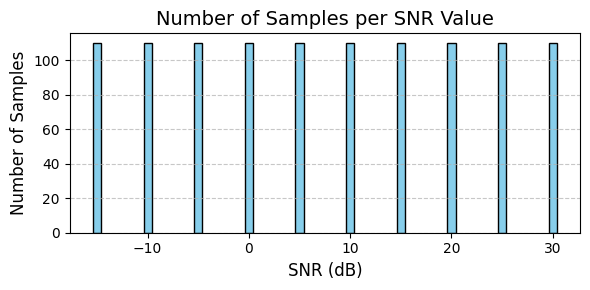

In [65]:
# Create a dictionary to store the count of rows for each SNR
row_counts = {}

# Count rows for each SNR value
for snr in snr_ranges:
    df = pd.read_csv(f'data/results_snr_{snr}dB.csv')
    row_counts[snr] = len(df)

# Create histogram
plt.figure(figsize=(6, 3))
plt.bar(list(row_counts.keys()), list(row_counts.values()), 
        color='skyblue', edgecolor='black')

# Customize the plot
plt.xlabel('SNR (dB)', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Number of Samples per SNR Value', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

plt.tight_layout()
plt.show()

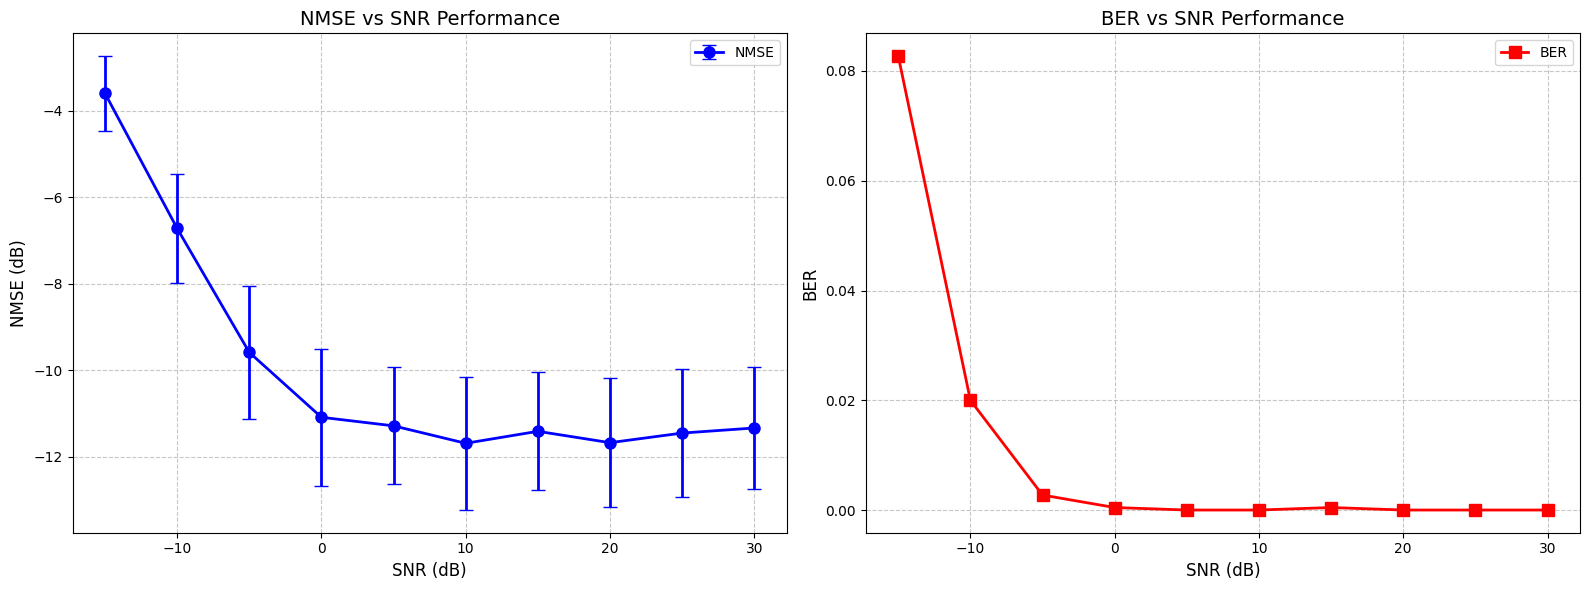

In [66]:
# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

snr = list(NMSE_mean_dict.keys())
nmse = list(NMSE_mean_dict.values())
nmse_std = list(NMSE_std_dict.values())
ber = list(BER_mean_dict.values())

# Plot NMSE with std dev error bars
ax1.errorbar(snr, nmse, 
             yerr=nmse_std,
             marker='o', linestyle='-', linewidth=2, markersize=8,
             color='blue', label='NMSE', capsize=5)
ax1.set_xlabel('SNR (dB)', fontsize=12)
ax1.set_ylabel('NMSE (dB)', fontsize=12)
ax1.set_title('NMSE vs SNR Performance', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.grid(True, which='minor', linestyle=':', alpha=0.4)
ax1.legend()

# Plot BER without error bars
ax2.plot(snr, ber, 
         marker='s', linestyle='-', linewidth=2, markersize=8,
         color='red', label='BER')
ax2.set_xlabel('SNR (dB)', fontsize=12)
ax2.set_ylabel('BER', fontsize=12)
ax2.set_title('BER vs SNR Performance', fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.grid(True, which='minor', linestyle=':', alpha=0.4)
ax2.legend()

plt.tight_layout()
plt.show()